In [1]:
allow_train = True
freeze_encoder = False
EPOCHS = 20
BATCH_SIZE = 128
shrink_size = 20

p = 0.2 # probability for augmentation
lr = 0.1
weight_deacay = 1e-4
T_max = 5
eta_min = 0.0

In [2]:
import torch
import torchvision
from torch import nn
from torchinfo import summary
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt

from going_modular.custom_data_setup_main_train import LoadDataset_IDRID
from going_modular import engine, utils
from going_modular import custom_data_setup_pre_train
from going_modular.ThreeHeadCNN import ThreeHeadCNN
import helper_functions

c:\Users\Amiroodi\AppData\Local\Programs\Python\Python311\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
c:\Users\Amiroodi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [3]:
# Set matmul precision for TF32 usage on Ampere+ GPUs
# torch.set_float32_matmul_precision('medium')

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Augmentation

In [4]:
A_transforms = helper_functions.get_augmentation_A_transforms(p)
no_transforms = helper_functions.get_augmentation_no_transforms()

In [5]:
# load all dataloaders

exp_dataloader, class_names = custom_data_setup_pre_train.create_test_dataloader(transform=no_transforms,
                                                                                        batch_size=BATCH_SIZE,
                                                                                        shrink_size=shrink_size) 

test_dataloader, class_names = custom_data_setup_pre_train.create_test_dataloader(transform=A_transforms, 
                                                                                        batch_size=BATCH_SIZE,
                                                                                        shrink_size=shrink_size) 

train_dataloader, class_names = custom_data_setup_pre_train.create_train_dataloader(transform=A_transforms, 
                                                                                        batch_size=BATCH_SIZE,
                                                                                        shrink_size=shrink_size) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


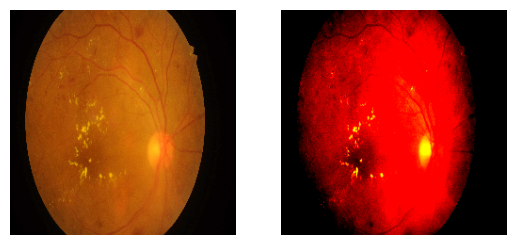

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


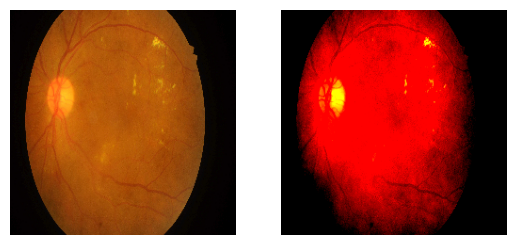

In [7]:
# plot some of the images to check applied augmentations

IDRID_image_folder = "../../IDRID/Imagenes/Imagenes" 
IDRID_csv_file = "../../IDRID/idrid_labels.csv"  

test_dataset_with_transform = LoadDataset_IDRID(IDRID_image_folder, IDRID_csv_file, transform=A_transforms)
test_dataset_no_transform = LoadDataset_IDRID(IDRID_image_folder, IDRID_csv_file, transform=no_transforms)

for i in range(2):
    img_2 = test_dataset_with_transform[i][0].permute(1, 2, 0)
    img_1 = test_dataset_no_transform[i][0].permute(1, 2, 0)
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(img_1.numpy())
    axes[1].imshow(img_2.numpy())
    axes[0].axis(False)
    axes[1].axis(False)
    plt.show()

In [8]:
model = ThreeHeadCNN().to(device)

In [9]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
if freeze_encoder:
    for param in model.encoder.parameters():
        param.requires_grad = False

In [10]:
# Print a summary using torchinfo (uncomment for actual output)
torch.manual_seed(33)
summary(
model=model, 
input_size=(32, 3, 240, 240), # make sure this is "input_size", not "input_shape"
col_names=["input_size", "output_size", "num_params", "trainable"],
col_width=20,
row_settings=["var_names"]) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ThreeHeadCNN (ThreeHeadCNN)                                  [32, 3, 240, 240]    [32, 5]              --                   True
├─Sequential (encoder)                                       [32, 3, 240, 240]    [32, 1280, 8, 8]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 240, 240]    [32, 32, 120, 120]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 240, 240]    [32, 32, 120, 120]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 120, 120]   [32, 32, 120, 120]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 120, 120]   [32, 32, 120, 120]   --                   --
│    └─Sequential (1)                                        [32, 32, 120, 120]   [32, 16, 120

In [11]:
# Define loss and optimizer

# weights = torch.Tensor([1.87, 12.61, 4.1, 14.9, 13.12]) * 0.2
# weights.to(device)

# loss_fn_classification = nn.CrossEntropyLoss(weight=weights).to(device)
loss_fn_classification = nn.CrossEntropyLoss().to(device)

# loss_fn_regression = nn.L1Loss(reduction='none').to(device)
loss_fn_regression = nn.L1Loss().to(device)

# loss_fn_ordinal = nn.BCEWithLogitsLoss(weight=weights).to(device)
loss_fn_ordinal = nn.BCEWithLogitsLoss().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_deacay)
scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

In [12]:
train_results = []

if allow_train:
    # Set the random seeds
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    # Start the timer
    from timeit import default_timer as timer 
    start_time = timer()

    # Setup training and save the results
    train_results = engine.pre_train(
        model=model,
        train_dataloader=train_dataloader,
        optimizer=optimizer,
        scheduler=scheduler,
        loss_fn_classification=loss_fn_classification,
        loss_fn_regression=loss_fn_regression,
        loss_fn_ordinal=loss_fn_ordinal,
        epochs=EPOCHS,
        device=device)
        
    # End the timer and print out how long it took
    end_time = timer()
    print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

    utils.save_model(model=model, target_dir='models', model_name='pre_train_model.pth')
else:
    model.load_state_dict(torch.load('models/pre_train_model.pth', weights_only=True, map_location=device))

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1
loss_classification_train: 1.6879 | loss_regression_train: 0.6750 | loss_ordinal_train: 0.7145

Epoch: 2
loss_classification_train: 1.4523 | loss_regression_train: 0.6874 | loss_ordinal_train: 0.6905

Epoch: 3
loss_classification_train: 1.2699 | loss_regression_train: 0.6979 | loss_ordinal_train: 0.6811

Epoch: 4
loss_classification_train: 1.1503 | loss_regression_train: 0.6664 | loss_ordinal_train: 0.6620



KeyboardInterrupt: 

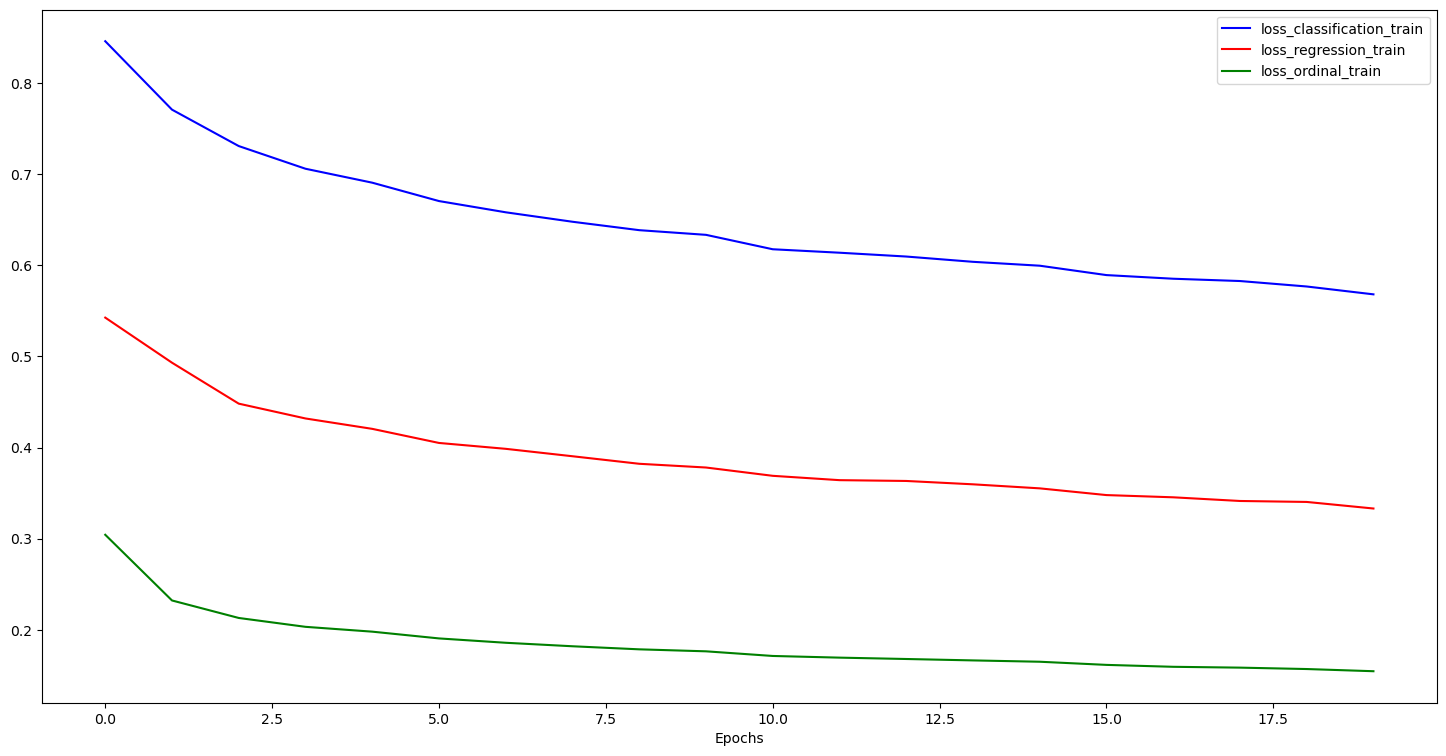

In [ ]:
if allow_train:
    helper_functions.plot_loss_curves_pre_train(train_results)

In [ ]:
test_results = engine.test_step(
    model=model,
    dataloader=test_dataloader,
    loss_fn_classification=loss_fn_classification,
    loss_fn_regression=loss_fn_regression,
    loss_fn_ordinal=loss_fn_ordinal,
    device=device)

f1_class: tensor([0.8962, 0.0238, 0.4691, 0.3138, 0.4026]) | f1_reg: tensor([0.8969, 0.0695, 0.4121, 0.2835, 0.2923]) | f1_ord: tensor([0.8967, 0.0659, 0.4723, 0.3334, 0.3789])
test class acc: 0.8005419649960223 | test reg acc: 0.7811919915141873 | test ord acc: 0.792897275258552
